# Language identification model construction

## Objectives

* Perform a simple exploration over a text dataset of language identification
* Build a simple neural network for automatic identification of language (english, spanish and german)
* **[later]** Review some of the basic tools for building an end-to-end pipeline for a text classification task.
* **[later]** Deploy the trained model on Heroku

## Requirements

* tensorflow==2.8.0
* pandas==1.3.5
* numpy==1.21.5
* scikit-learn==1.0.2
* matplotlib==3.2.2
* nltk==3.2.5
* pydot==1.3.0

In [ ]:
# Run only if you want to install the packages inside the notebook
# %pip install tensorflow==2.8.0 pandas==1.3.5 numpy==1.21.5 scikit-learn==1.0.2 matplotlib==3.2.2 nltk==3.2.5

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import nltk
import tensorflow as tf
import pandas as pd#
import numpy as np
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sklearn import preprocessing

from tensorflow.keras import layers
from tensorflow.keras import losses

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ssierra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ssierra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Check TF version

print(tf.__version__)

2.8.0


# Data importation

In this step, we will use a dataset of 90k samples consisting of text passages and their corresponding language label. This dataset contains samples from 20 different languages. However for our example we will focus on 3 different languages: English, Spanish and German. [Further information can be found here](https://huggingface.co/datasets/papluca/language-identification)

In [3]:
# Define our directory for saving the dataset

DATA_DIRECTORY = "data"

In [9]:
# Download data and save it into the data folder

!rm -rf {DATA_DIRECTORY}
!wget https://huggingface.co/datasets/papluca/language-identification/resolve/main/train.csv
!wget https://huggingface.co/datasets/papluca/language-identification/resolve/main/valid.csv
!wget https://huggingface.co/datasets/papluca/language-identification/resolve/main/test.csv
!mkdir -p {DATA_DIRECTORY}
!mv *.csv {DATA_DIRECTORY}

--2022-03-17 16:26:37--  https://huggingface.co/datasets/papluca/language-identification/resolve/main/train.csv
Resolving huggingface.co (huggingface.co)... 2600:1f18:147f:e850:4e87:e217:2e92:4bdd, 2600:1f18:147f:e800:7c26:7b12:8f9a:5604, 2600:1f18:147f:e850:6c0d:9a67:3e5:c11, ...
Connecting to huggingface.co (huggingface.co)|2600:1f18:147f:e850:4e87:e217:2e92:4bdd|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/datasets/papluca/language-identification/f180d78a1f0e758fd33bb1bae37f62eebc538d78ece2affb3d05a967850ba474 [following]
--2022-03-17 16:26:37--  https://cdn-lfs.huggingface.co/datasets/papluca/language-identification/f180d78a1f0e758fd33bb1bae37f62eebc538d78ece2affb3d05a967850ba474
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 2600:9000:225a:c800:11:f807:5180:93a1, 2600:9000:225a:f200:11:f807:5180:93a1, 2600:9000:225a:a600:11:f807:5180:93a1, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co

In [4]:
# Load data in pandas for filtering

train_df = pd.read_csv(f"{DATA_DIRECTORY}/train.csv")
val_df = pd.read_csv(f"{DATA_DIRECTORY}/valid.csv")
test_df = pd.read_csv(f"{DATA_DIRECTORY}/test.csv")

In [5]:
# Select only "en", "es" and "de"
lang_list = ["es", "en", "de"]

train_df = train_df.loc[train_df.labels.isin(lang_list)]
val_df = val_df.loc[val_df.labels.isin(lang_list)]
test_df = test_df.loc[test_df.labels.isin(lang_list)]

# Data exploration

In this step, we will perform a simple analysis of some important characteristics of our dataset:

* Word frequency distribution
* Distribution of labels 
* Text passage length distribution

In [6]:
# We calculate a list of words (tokens) which will be used for evaluate the distribution of
# tokens in the dataset

# We declare a stoplist for the three used languages
stoplist = [stopwords.words(lang) for lang in ["english", "spanish", "german"]]
stoplist = set([word for lang_list in stoplist for word in lang_list])

# Now, only for visualization purposes we create a listh with all the tokens
word_list = []
for sentence in train_df["text"].to_list():
    word_list += [word for word in word_tokenize(sentence) if word not in stoplist]

print(len(word_list))

227738


Our corpus consists of 227K different words.

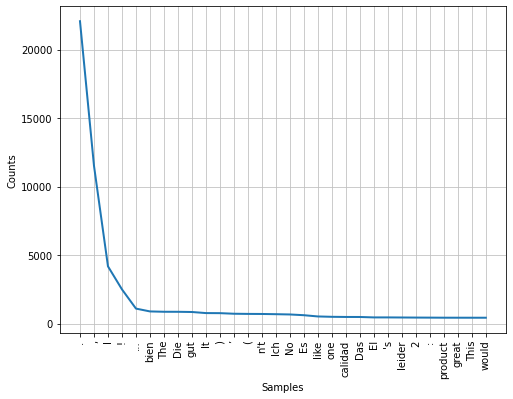

In [7]:
plt.figure(figsize=(8, 6)) 

fd = FreqDist(word_list)
fd.plot(30)


In [8]:
# Review the distribution of labels

train_df.labels.value_counts()

es    3500
de    3500
en    3500
Name: labels, dtype: int64

## Exploring the length of the text sequences

Before we define a base architecture in TensorFlow, we must find a good value for the size of the input of the model. We evaluate the average size of each sample of the corpus.

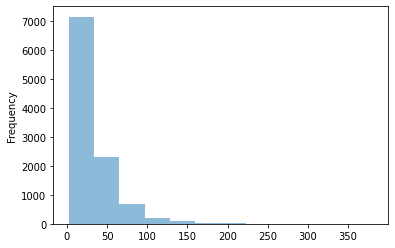

In [9]:
# We then evaluate the size of each sentence in the corpus

splitted_text = train_df['text'].apply(lambda txt: txt.split(' '))
splitted_text_len = splitted_text.apply(lambda x: len(x))
ax = splitted_text_len.plot.hist(bins=12, alpha=0.5)

In [10]:
print("Average length: {}".format(splitted_text_len.mean()))
print("Maximum length: {}".format(splitted_text_len.max()))
print("Standard deviation length: {}".format(splitted_text_len.std()))

Average length: 31.605238095238096
Maximum length: 381
Standard deviation length: 29.969598705150254


We have selected $50$, as it covers up to 68% of the data (one standard deviation). Sequences longer than $50$ words will be chunked. **This is done for the sake of simplicity** 

# Data preparation
## Using `tf.data` for creating the dataset

`tf.data` is one of the most useful libraries for accessing datasets in TensorFlow. It provides several handlers for reading and creating usable datasets with low memory footprint. In this section we:

* Transform the language labels to integers
* Build the datasets using `tf.data`
* Transform the text input into sequences of up to 50 integers (vectorization)

In [11]:
# Create dictionary for enconding labels
# This is done using LabelEncoder from scikit-learn
# It's quite useful when the number if classes is high

le = preprocessing.LabelEncoder()
le.fit(lang_list)

num_classes = len(le.classes_)

train_labels = tf.keras.utils.to_categorical(le.transform(train_df.pop('labels')), num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(le.transform(val_df.pop('labels')), num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(le.transform(test_df.pop('labels')), num_classes=num_classes)

In [12]:
# We build then the datasets using tf.data
raw_train_ds = tf.data.Dataset.from_tensor_slices((train_df["text"].to_list(), train_labels)) # X, y
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_df["text"].to_list(), val_labels))
raw_test_ds = tf.data.Dataset.from_tensor_slices((test_df["text"].to_list(), test_labels))

2022-04-05 22:10:02.827880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 22:10:02.832052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 22:10:02.832299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 22:10:02.833096: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [13]:
# Exploring a sample of the corpus

batch_size = 32
seed = 42

for text, label in raw_train_ds.take(1):
    print("Text: ", text.numpy())
    print("Label:", label.numpy())

Text:  b'Un producto de una calidad y capacidad incre\xc3\xadbles que ser\xc3\xa1 el placer de todo amante de la tecnolog\xc3\xada'
Label: [0. 0. 1.]


As you can see, the dataset is still raw, which means, it's still composed of text sequences.

## Preprocessing the dataset using `tf.keras.layers.TextVectorization`

Before we feed our dataset to the model, we have to build a vectorized representation of each text using `tf.keras.layers.TextVectorization`. This layer can help to:

* Preprocess the text data using common and custom standardization techniques
* Transforms words into integers ("book" --> 45) 

We decided to keep the top $10.000$ most frequent words using the `TextVectorization` class.

In [14]:
# Prepare dataset for training

max_features = 10000 # top 10K most frequent words
sequence_length = 50 # We defined it in the previous data exploration section

vectorize_layer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

This step is important to perform it only on the training set. The `adapt()` method will learn the vocabulary for our dataset

In [15]:
# train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_df["text"].to_list()) # vectorize layer is fitted to the training data

In [16]:
# Helper for visualizing the processed input
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
# Reviewing how a sample of the corpus will be fed to the model

text_batch, label_batch = next(iter(raw_train_ds.batch(64)))
first_review, first_label = text_batch[0], label_batch[0]
print("First text: ", first_review)
print("Language (label)", le.inverse_transform([np.argmax(first_label)]))
print("Vectorized text", vectorize_text(first_review, first_label))

First text:  tf.Tensor(b'Un producto de una calidad y capacidad incre\xc3\xadbles que ser\xc3\xa1 el placer de todo amante de la tecnolog\xc3\xada', shape=(), dtype=string)
Language (label) ['es']
Vectorized text (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[  39,  112,    5,   61,   85,   11, 2033,    1,    7, 2603,   16,
           1,    5,  162,    1,    5,   13, 7611,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)


In [18]:
# Evaluate the vocabulary of the vectorize layer

print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  utilizar
 313 --->  box
Vocabulary size: 10000


In [19]:
# Create the final datasets using the vectorize_layer

train_ds = raw_train_ds.map(lambda x, y: (vectorize_layer(x), y)) # returns vectorize_layer(text), label
val_ds = raw_val_ds.map(lambda x, y: (vectorize_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (vectorize_layer(x), y))

In [20]:
# Applying cache techniques for improving inference and training time
# It allows tensorflow to prepare the data while it trains the model

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.batch(batch_size=batch_size)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size=batch_size)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size=batch_size)
test_ds = test_ds.prefetch(AUTOTUNE)

# Model training and specification

Our simple architecture is defined as follows:
* `Embedding` layer for building a more dense and compact representation for each of the top 10.000 most frequent words
* `Dropout` layer for improving regularization
* `GlobalAveragePooling1D` for returning a fixed-length ouput vector for each example. It averages over the sequence dimension, allowing the model to handle variable size inputs (less than 50) in a simple way.
* `Dense` layer for the logits of each class (es, en, de)

In [21]:
# Model training

embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(3)])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
__________________________________________________

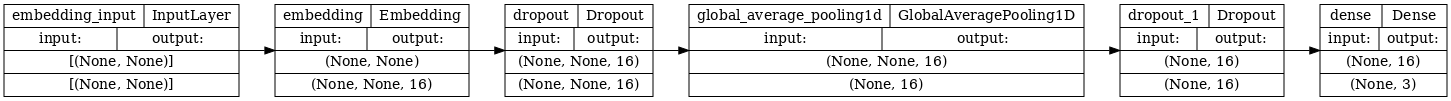

In [22]:
tf.keras.utils.plot_model(model=model , rankdir="LR", dpi=72, show_shapes=True)


In [23]:
# Specify loss, optimizer and metrics

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
# Train

epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
329/329 [==============================] - 2s 3ms/step - loss: 0.8936 - accuracy: 0.8833 - val_loss: 0.6346 - val_accuracy: 0.9913
Epoch 2/10
329/329 [==============================] - 1s 3ms/step - loss: 0.5246 - accuracy: 0.9923 - val_loss: 0.4523 - val_accuracy: 0.9967
Epoch 3/10
329/329 [==============================] - 1s 3ms/step - loss: 0.4419 - accuracy: 0.9981 - val_loss: 0.4241 - val_accuracy: 0.9980
Epoch 4/10
329/329 [==============================] - 1s 3ms/step - loss: 0.4245 - accuracy: 0.9984 - val_loss: 0.4170 - val_accuracy: 0.9993
Epoch 5/10
329/329 [==============================] - 1s 3ms/step - loss: 0.4178 - accuracy: 0.9990 - val_loss: 0.4127 - val_accuracy: 0.9993
Epoch 6/10
329/329 [==============================] - 1s 3ms/step - loss: 0.4124 - accuracy: 0.9995 - val_loss: 0.4090 - val_accuracy: 0.9993
Epoch 7/10
329/329 [==============================] - 1s 3ms/step - loss: 0.4075 - accuracy: 0.9996 - val_loss: 0.4054 - val_accuracy: 0.9993
Epoch 

In [25]:
# Evaluate the model

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

47/47 [==============================] - 0s 2ms/step - loss: 0.3979 - accuracy: 0.9993
Loss:  0.39792943000793457
Accuracy:  0.9993333220481873


Keys of the history variable
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


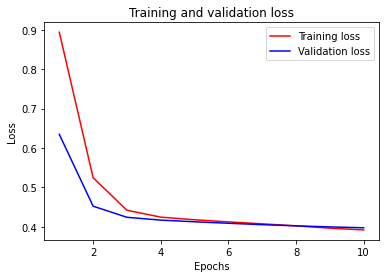

In [26]:
# Plot loss

history_dict = history.history
print("Keys of the history variable")
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


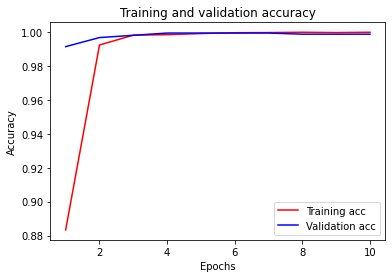

In [27]:
# Plot accuracy

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [28]:
examples = [
  "Esto me pareció increíble",
  "I think it was incredible.",
  "Ich finde es war unglaublich"
]

examples_vectorized = vectorize_layer(examples)

In [37]:
# Now we test it with some predictions
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

examples = [
  "Esto me pareció increíble",
  "I think it was incredible.",
  "Ich finde es war unglaublich"
]

examples_vectorized = vectorize_layer(examples)

logits = model.predict(examples_vectorized)
probits = softmax(logits)
idx_predictions = np.argmax(probits, axis=1)
print("Probabilities: {}".format(np.max(probits, axis=1)))
print("Corresponding classes: {}".format(le.inverse_transform(idx_predictions)))

Probabilities: [0.4065224 0.4377388 0.4221917]
Corresponding classes: ['es' 'en' 'de']


In [41]:
# Save the model

!mkdir -p saved_model

model.save('saved_model/simple_mlp_novectorize.h5')

**Achtung**: Here we are only saving the tf model. Neither the vectorize layer nor the LabelEncoder weren't saved. This will be part of our next session.

In [ ]:
# Load the model
saved_model = tf.keras.models.load_model('saved_model/simple_mlp_novectorize.h5')

# Build an end-to-end model

We need to connect the `TextVectorization` layer, the model and add a Softmax activation layer in order to transform the logits into probabilities (probits). Which will be useful for generating predictions.

In [25]:
# Exporting the model

export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('softmax')
])

export_model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

# Test it with `raw_test_ds`, but batch it first!
raw_test_batches = raw_test_ds.batch(batch_size=batch_size)
loss, accuracy = export_model.evaluate(raw_test_batches)
print(accuracy)


47/47 [==============================] - 0s 995us/step - loss: 0.1752 - accuracy: 0.9993
0.9993333220481873


## Testing the end-to-end model

In [36]:
examples = [
  "Esto me pareció increíble",
  "I think it was incredible.",
  "Ich finde es war unglaublich"
]

predictions = export_model.predict(examples)
idx_predictions = np.argmax(predictions, axis=1)
print(np.max(predictions, axis=1))
print(le.inverse_transform(idx_predictions))

[0.46706444 0.49751717 0.33924365 0.3549572  0.3549572 ]
['es' 'en' 'de' 'en' 'en']


## Saving the model

In [30]:
!mkdir -p saved_model

export_model.save('saved_model/simple_mlp')

2022-03-30 22:00:18.332035: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/simple_mlp/assets


Now we have to save also the `LabelEncoder` object. This will be useful when the number of classes increases.

In [31]:
import joblib

joblib.dump(le, 'label_encoder.joblib')

# load
# le = joblib.load('label_encoder.joblib')

['label_encoder.joblib']

In [ ]:
# For loading the model use:
new_model = tf.keras.models.load_model('saved_model/simple_mlp')